In [ ]:
! pip install anchor-exp graphviz

In [119]:
import pathlib
pathlib.Path().resolve()

PosixPath('/home/mmozolewski')

In [120]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("notebooks/knack/knac")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import math

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
from anchor import utils
from anchor import anchor_tabular
#from knac import KNAC
from knac_scikit import KnacSplits, KnacMerges
from knac_helpers import caption_clusters, find_centers,prepareDf2
import matplotlib.patches as patches
import matplotlib as mlp
import seaborn as sns

from sklearn.datasets import make_blobs, make_classification, make_circles
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [4]:
def plot_roc(model, dataset, features, target, saveas=None):
    from itertools import cycle

    from sklearn import svm, datasets
    from sklearn.metrics import roc_curve,auc
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    from scipy import interp
    
    n_classes = len(np.unique(dataset[target]))
    
    if hasattr(model ,'decision_function'):
        y_score = model.decision_function(dataset[features])
    else:
        if n_classes < 3:
            y_score = model.predict_proba(dataset[features])[::,1]
        else:
            y_score = model.predict_proba(dataset[features])
    y = label_binarize(dataset[target], classes=np.unique(dataset[target]))


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        if n_classes > 2:
            fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        else:
            fpr[i], tpr[i], _ = roc_curve(dataset[target], y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    if n_classes > 2:
        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    else:
        fpr["micro"], tpr["micro"], _ = roc_curve(dataset[target], y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2

    fig=plt.figure(figsize=(12,9))
    plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'gold', 'khaki', 'red', 'violet','purple'])
    for i, color in zip(range(n_classes), colors):
          plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC analysis')
    plt.legend(loc="lower right")
    plt.show()
    if saveas is not None:
        fig.savefig(saveas)

def get_rules(tree, feature_names, class_names):
    from sklearn.tree import _tree
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]

    return rules

def justify_splits_anchor(expert_to_split, split_recoms, data, features, target_automatic='C'):
    model = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
    model.fit(data[features].values,data[target_automatic])
    ds = data[data[target_automatic].isin(split_recoms)]
    centers_anchor = ds.groupby(target_automatic).mean()

    explainerx = anchor_tabular.AnchorTabularExplainer(
        ds.C.to_list(),
        feature_names = centers_anchor[features].columns,

        train_data = ds[features].values)


    for idx in split_recoms:
        exp = explainerx.explain_instance(centers_anchor[features].loc[idx].values, model.predict, threshold=0.85)
        print(f'The rule for automatic cluster {idx}: %s' % (' AND '.join(exp.names())))
        print('Precision: %.2f' % exp.precision())
        print('Coverage: %.2f' % exp.coverage())

def justify_splits_tree(expert_to_split, split_recoms, data, features, target_automatic='C'):
    from sklearn import tree
    from graphviz import Source
    from IPython.display import SVG

    ds_local = data.copy()
    ds_local = ds_local[ds_local[target_automatic].isin(split_recoms)]
    centers_anchor_local = ds_local.groupby(target_automatic).mean()

    estimator_local_simple = tree.DecisionTreeClassifier(max_depth=1)
    estimator_local_simple.fit(ds_local[features], ds_local[target_automatic])


    graph = Source(tree.export_graphviz(estimator_local_simple, out_file=None
                                        , feature_names=features, class_names=[str(f) for f in estimator_local_simple.classes_]
                                        , filled = True))

    return get_rules(estimator_local_simple, feature_names=features, class_names=[str(cn) for cn in estimator_local_simple.classes_])


    #display(SVG(graph.pipe(format='svg')))

def justify_merges_anchor(merge_recoms, data, features, target_expert='E'):
    from sklearn.preprocessing import LabelEncoder
    model_exp = xgb.XGBClassifier(use_label_encoder=True,eval_metric='mlogloss') # TODO
    le_exp = LabelEncoder()
    le_exp.fit(data[target_expert])
    model_exp.fit(data[features].values,data[target_expert])
    ds_exp = data[data[target_expert].isin(merge_recoms)]
    centers_exp = ds_exp.groupby(target_expert).mean()

    explainer_exp = anchor_tabular.AnchorTabularExplainer(
        le_exp.classes_,
        feature_names = centers_exp[features].columns,
        train_data = data[features].values,
        categorical_names={})


    for idx in merge_recoms:
        exp = explainer_exp.explain_instance(centers_exp[features].loc[idx].values, model_exp.predict, threshold=0.85)
        print(f'The rule for automatic cluster {idx}: %s' % (' AND '.join(exp.names())))
        print('Precision: %.2f' % exp.precision())
        print('Coverage: %.2f' % exp.coverage())

def justify_merges_tree(merge_recoms, data, features, target_expert='E'):
    from sklearn import tree
    from graphviz import Source
    from IPython.display import SVG
    from sklearn.preprocessing import LabelEncoder

    le_exp = LabelEncoder()
    le_exp.fit(data[target_expert])
    ds_exp = data[data[target_expert].isin(merge_recoms)]
    centers_anchor_local = ds_exp.groupby(target_expert).mean()

    estimator_local_simple_exp = tree.DecisionTreeClassifier(max_depth=1)
    estimator_local_simple_exp.fit(ds_exp[features], le_exp.transform(ds_exp[target_expert]))


    graph = Source(tree.export_graphviz(estimator_local_simple_exp, out_file=None
                                        , feature_names=features, class_names=[str(f) for f in estimator_local_simple_exp.classes_]
                                        , filled = True))

    return get_rules(estimator_local_simple_exp, feature_names=features, class_names=[str(cn) for cn in estimator_local_simple_exp.classes_])
    #display(SVG(graph.pipe(format='svg')))


In [5]:
random_state = 170

# Blood pressure dataset

In [6]:
data = pd.read_csv('~/notebooks/knack/Semantic_Segmentation_TiltABP.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    40000 non-null  int64  
 1   abp     40000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 625.1 KB


<AxesSubplot:>

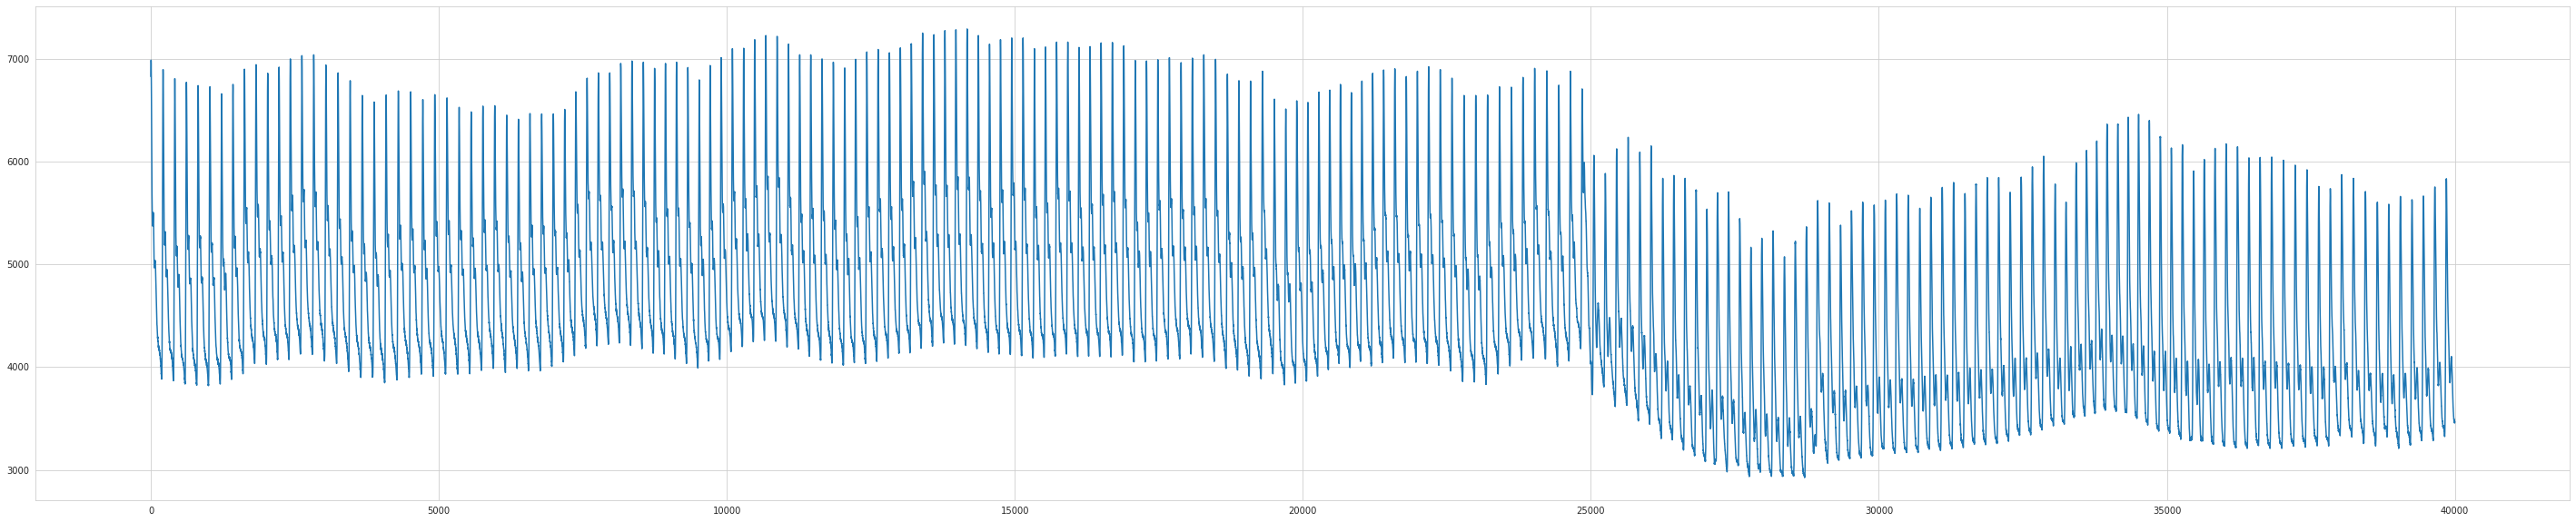

In [7]:
rcParams['figure.figsize'] = 50, 10
data["abp"].plot()

<AxesSubplot:>

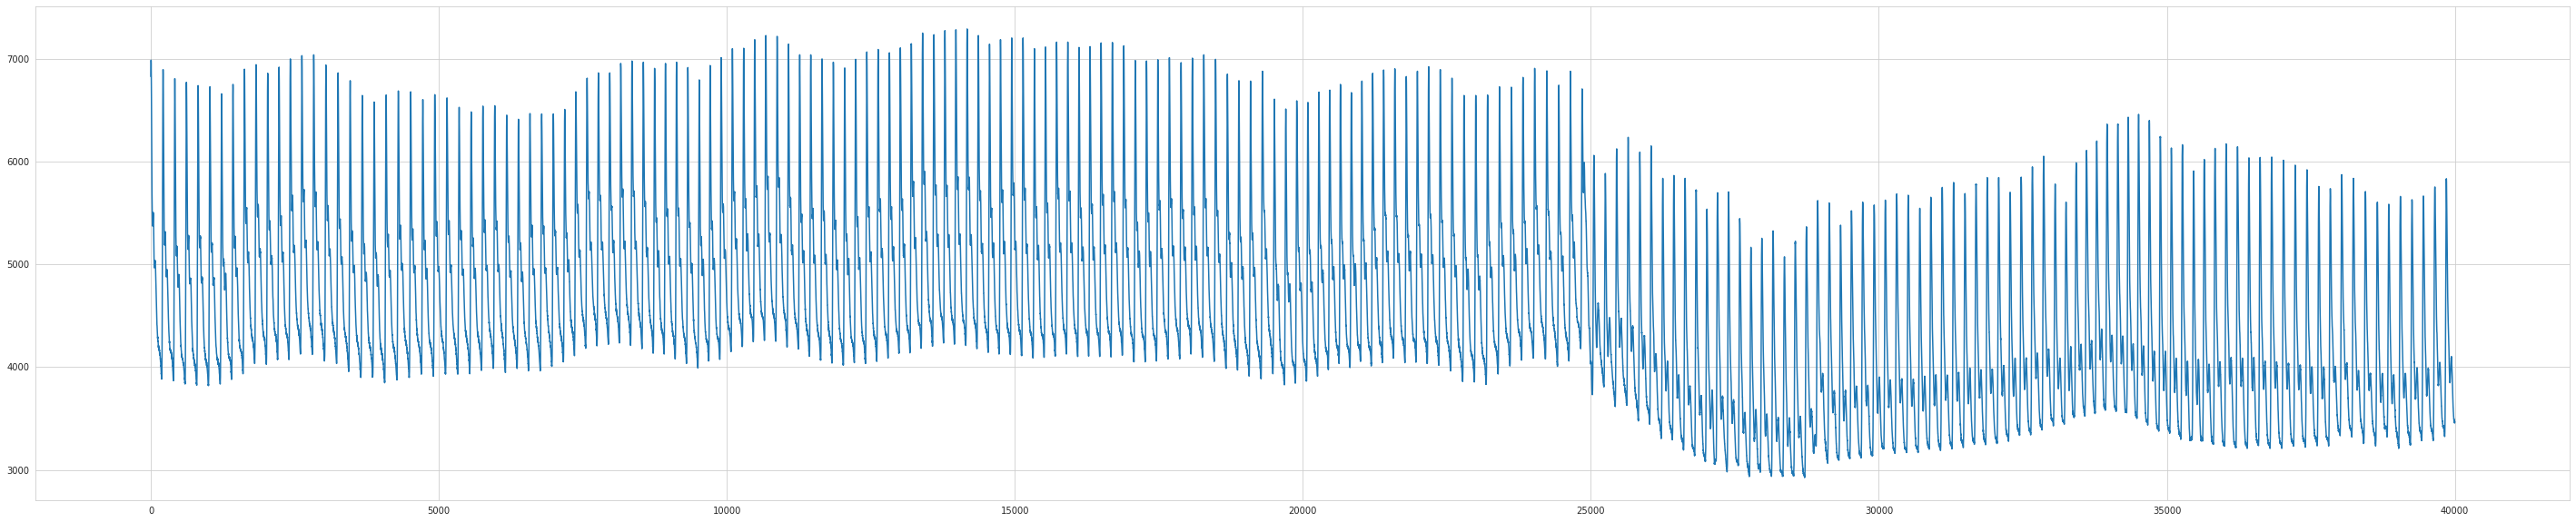

In [8]:
data.sort_values(by=['time'], inplace=True)
data["abp"].plot()

<AxesSubplot:>

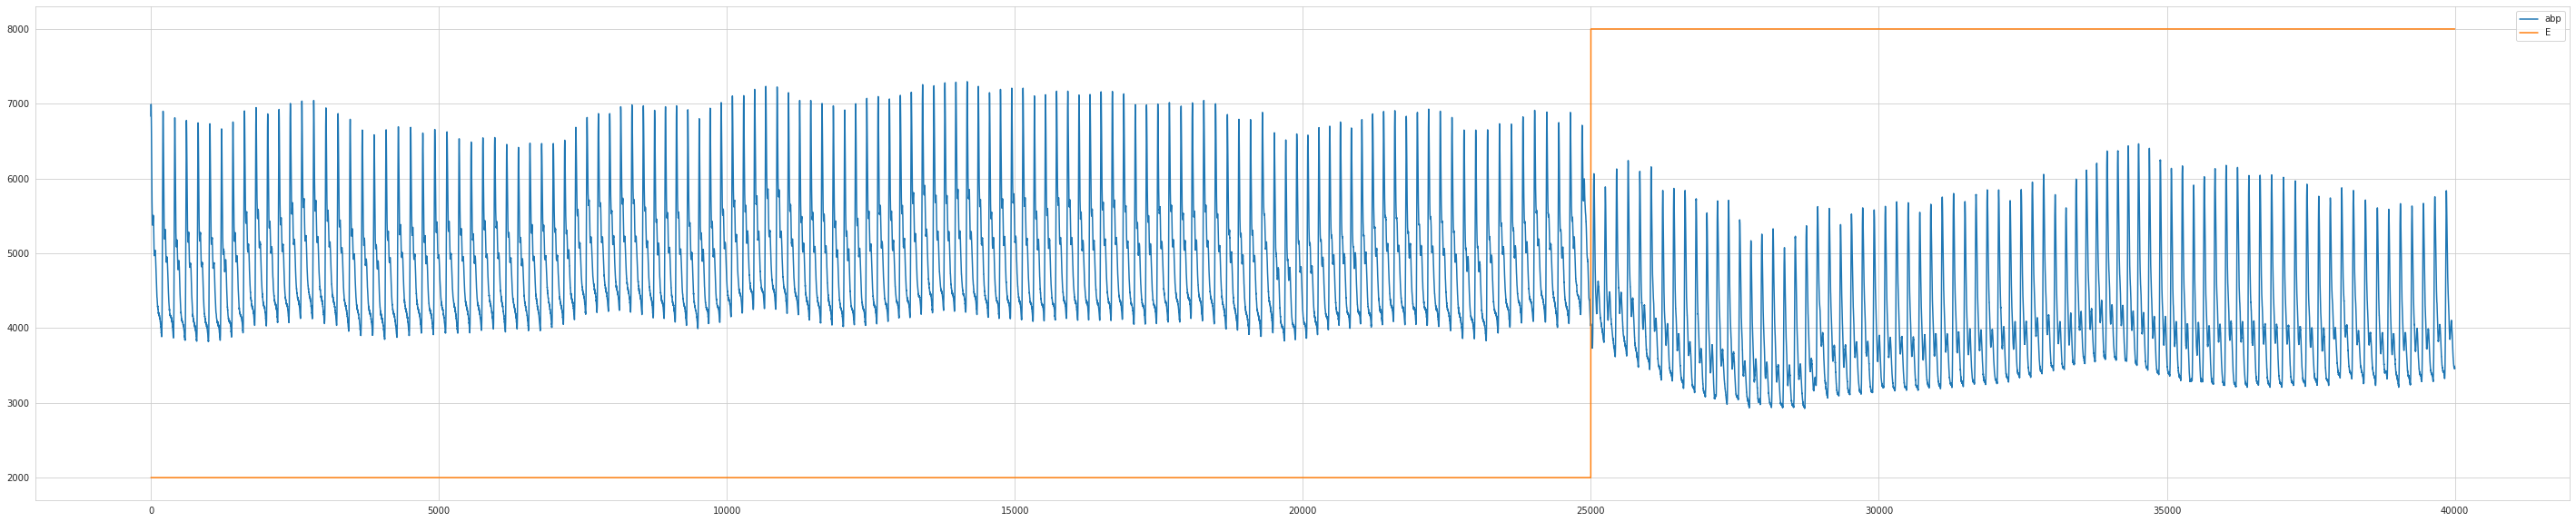

In [9]:
# data["E"] = data["time"].apply(lambda x: 2000 if x <= 25000.0 else 8000)
data.loc[0:25000, "E"] = 2000 ## FIX data error!
data.loc[25000:40000, "E"] = 8000 ## FIX data error!
data[["abp", "E"]].plot()

In [10]:
print(data.iloc[0:300][["time", "E"]])

     time       E
0       0  2000.0
1       1  2000.0
2       2  2000.0
3       3  2000.0
4       4  2000.0
..    ...     ...
295   295  2000.0
296   296  2000.0
297   297  2000.0
298   298  2000.0
299   299  2000.0

[300 rows x 2 columns]


<AxesSubplot:>

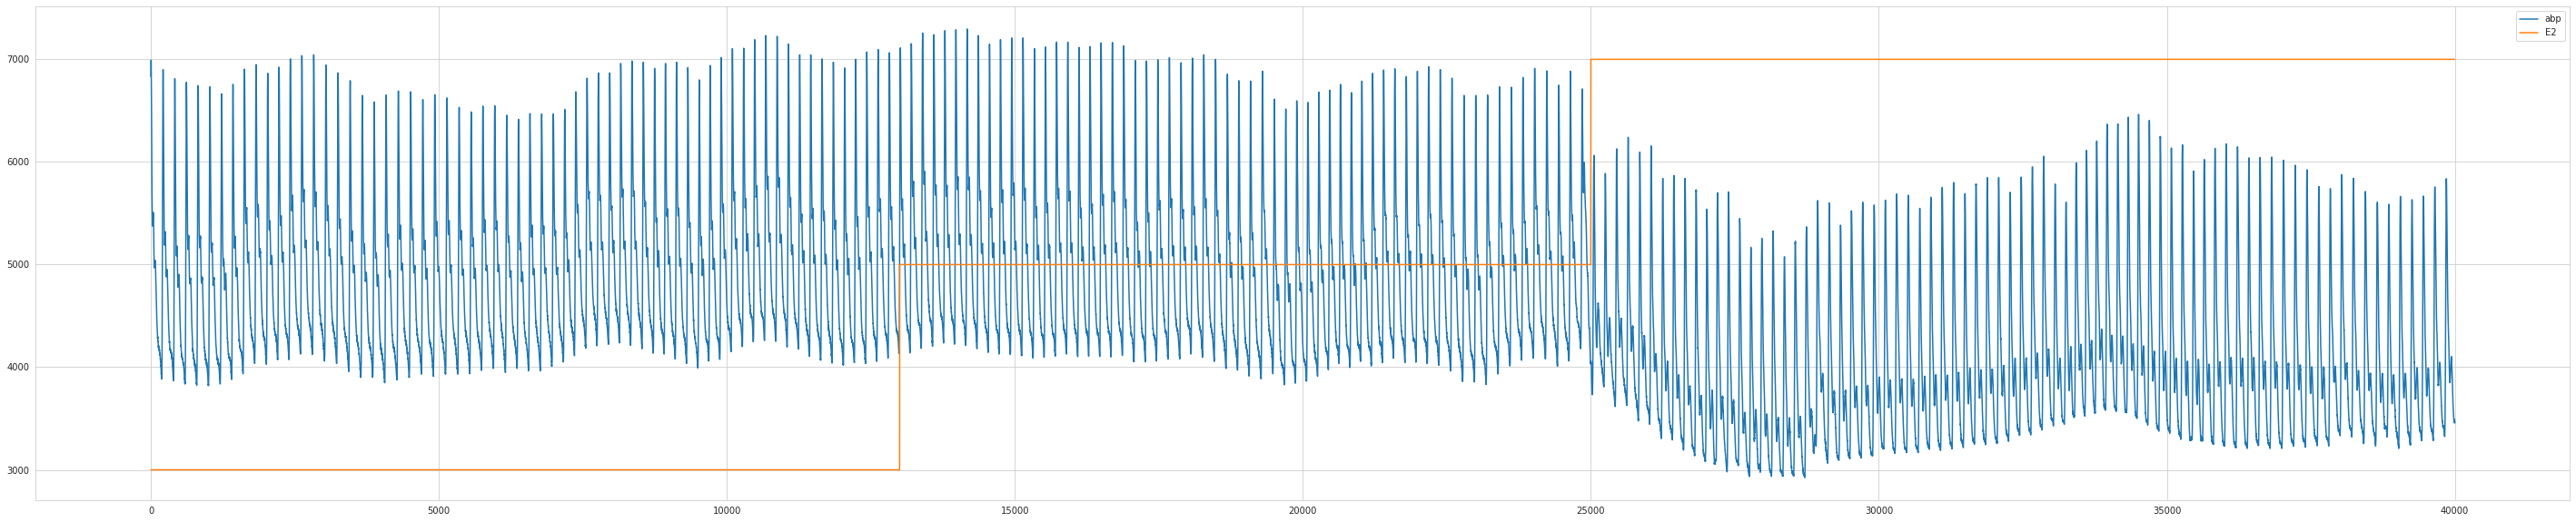

In [11]:
#### data["E2"] = data["time"].apply(lambda x: 3000 if x <= 13000.0 else 5000 if x <= 27000.0 else 7000)
# del data['E2']

# data["E2"] = data["time"].apply(lambda x: 3000 if x <= 13000.0 else 5000 if x <= 25000.0 else 7000)
data.loc[0:13000, "E2"] = 3000 ## FIX data error!
data.loc[13000:25000, "E2"] = 5000 ## FIX data error!
data.loc[25000:40000, "E2"] = 7000 ## FIX data error!
data[["abp", "E2"]].plot()

In [12]:
print(data.iloc[25001])

time    25001.0
abp      4060.0
E        8000.0
E2       7000.0
Name: 25001, dtype: float64


In [13]:
deep_vats_clusters_windows = pd.read_csv('~/notebooks/knack/clusters_windows_mozo_DeepVATS_ArterialBloodPressureDuringReclining_v3.csv')
deep_vats_clusters_windows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3980 entries, 0 to 3979
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   window_idx  3980 non-null   int64
 1   cluster     3980 non-null   int64
 2   obs_start   3980 non-null   int64
 3   obs_end     3980 non-null   int64
dtypes: int64(4)
memory usage: 124.5 KB


In [14]:
print(deep_vats_clusters_windows["cluster"].value_counts())

0    2188
2    1495
1     297
Name: cluster, dtype: int64


In [15]:
deep_vats_clusters = pd.read_csv('~/notebooks/knack/clusters_obs_mozo_DeepVATS_ArterialBloodPressureDuringReclining_v3.csv')
deep_vats_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   idx                40000 non-null  int64 
 1   clusters           40000 non-null  object
 2   most_freq_cluster  40000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 937.6+ KB


In [17]:
print(deep_vats_clusters["most_freq_cluster"].value_counts())

0    24751
2    14980
1      269
Name: most_freq_cluster, dtype: int64


In [18]:
print(deep_vats_clusters.iloc[39999])

idx                  39999
clusters                 2
most_freq_cluster        2
Name: 39999, dtype: object


In [19]:
data["C"] = deep_vats_clusters['most_freq_cluster']
data["C2"] = data["C"].apply(lambda x: 2999 if x == 0 else 4999 if x == 1 else 6999)

<AxesSubplot:>

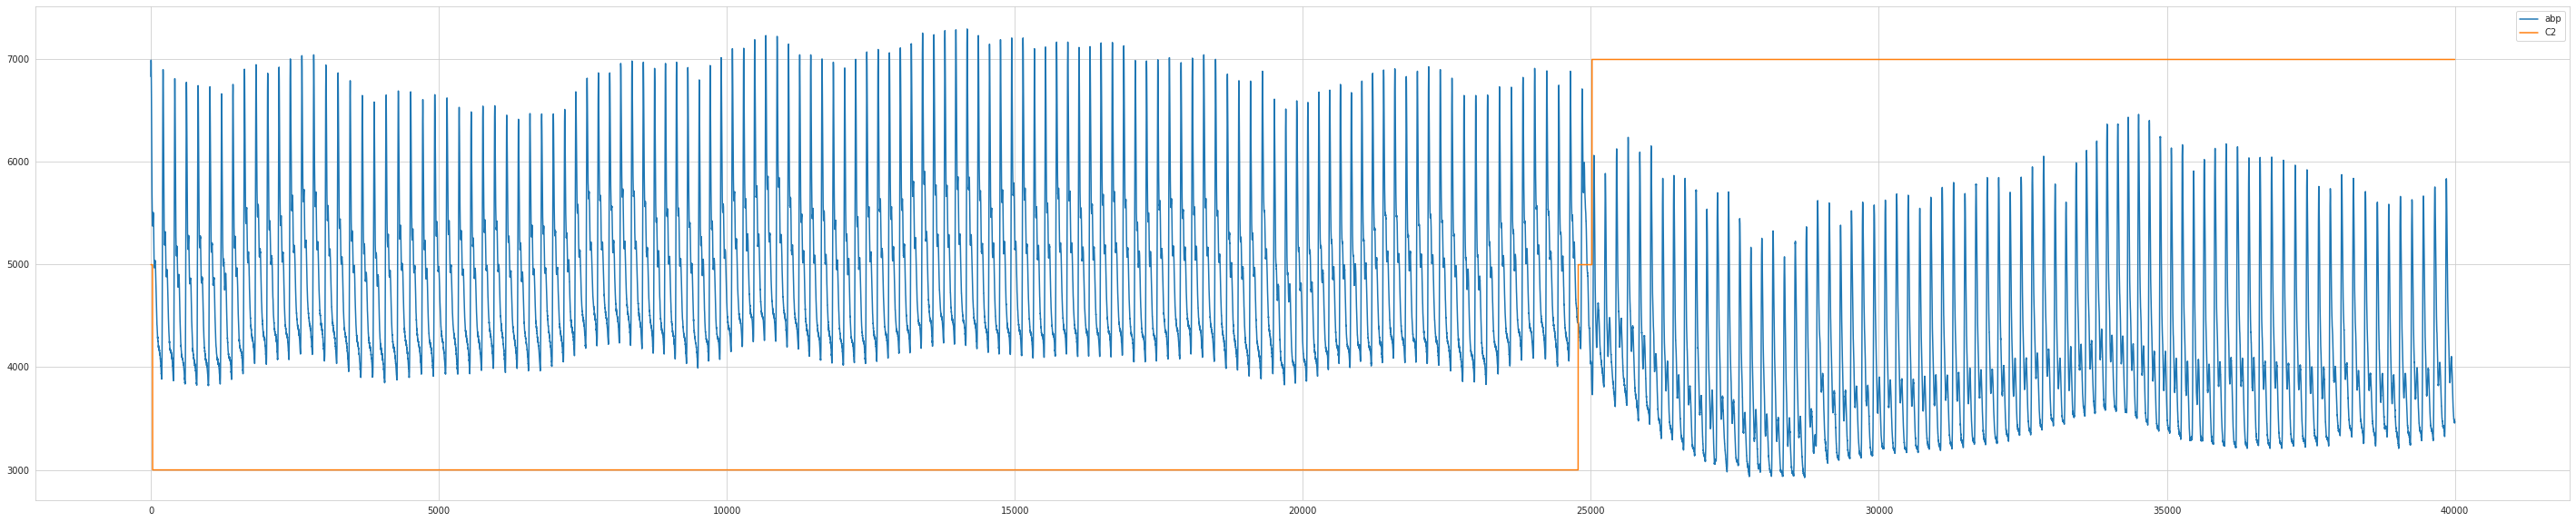

In [20]:
data[["abp", "C2"]].plot()

In [21]:
data.loc[24900:25100, ["time", "C2"]]

time    C2
24900  24900  4999
24901  24901  4999
24902  24902  4999
24903  24903  4999
24904  24904  4999
...      ...   ...
25096  25096  6999
25097  25097  6999
25098  25098  6999
25099  25099  6999
25100  25100  6999

[201 rows x 2 columns]

In [ ]:
## opcja - wzor wiktora

In [22]:
knack_df_split = data.pivot_table(index='E',columns='C',values='abp',aggfunc='count').fillna(0) 
knack_df_split

C             0      1        2
E                              
2000.0  24751.0  249.0      0.0
8000.0      0.0   20.0  14980.0

In [23]:
knac2_splits = KnacSplits(confidence_threshold=0.9, # Assign value from  range: (0.0 ; 1.0)
    silhouette_weight=0.2)    # Assign value from  range: (0.0 ; 1.0)
knac_splits_recoms = knac2_splits.fit_transform(knack_df_split, y=None, data=data[["abp", "E", "C"]], labels_automatic=data['C'].astype(str), labels_expert=data['E'])


In [24]:
print(knac_splits_recoms)

E
2000.0    [(0, 1), 0.8152534906047071]
Name: split, dtype: object


In [25]:
knack_df_merges = data.pivot_table(index='E2',columns='C',values='abp',aggfunc='count').fillna(0)
knack_df_merges

C             0      1        2
E2                             
3000.0  12971.0   29.0      0.0
5000.0  11780.0  220.0      0.0
7000.0      0.0   20.0  14980.0

In [26]:
knac1_merges = KnacMerges(confidence_threshold=0.9, # Assign value from  range: (0.0 ; 1.0)
                    metric='centroids_link',    # Select one of the following options ['single_link', 'average_link',
                                              #                                       'complete_link', 'centroids_link', 'wards_link']
                    metric_weight=0.2)        # Assign value from  range: (0.0 ; 1.0)
knac_merges_recoms=knac1_merges.fit_transform(knack_df_merges, data=data[["abp", "E2", "C"]].values,labels_expert=data['E2'])

In [27]:
knac_merges_recoms

C1      C2  similarity
1  3000.0  5000.0    0.902261

## Explain splits
  * We explain differences between two clusters with complex model, and Anchor
  * We explain splits by building surogate decision tree on the subset containing only these splited data


### Explanation based on complex model and anchor

In [28]:
def get_agg_stats(df:pd.DataFrame, by:str) -> pd.DataFrame:
    df.sort_values(by=[by], inplace=True)
    data_agg = df.groupby(by).apply(lambda grp: grp.mean())["abp"].reset_index()
    data_agg.rename(columns={"abp": "abp_mean"}, inplace=True)
    data_agg["abp_std"] =\
        df.groupby(by).apply(lambda grp: grp.std())["abp"].reset_index()["abp"]
    data_agg["abp_min"] =\
        df.groupby(by).apply(lambda grp: grp.min())["abp"].reset_index()["abp"]
    data_agg["abp_max"] =\
        df.groupby(by).apply(lambda grp: grp.max())["abp"].reset_index()["abp"]
    df.sort_values(by=['time'], inplace=True)
    return data_agg#.reset_index()

get_agg_stats(data, 'C')

C     abp_mean     abp_std  abp_min  abp_max
0  0  4917.306775  750.352866   3820.0   7296.0
1  1  5074.230483  860.811292   3768.0   6992.0
2  2  4008.701736  739.920984   2924.0   6464.0

In [30]:
data_agg_by_c = get_agg_stats(data, 'C')
data_agg_by_c

C     abp_mean     abp_std  abp_min  abp_max
0  0  4917.306775  750.352866   3820.0   7296.0
1  1  5074.230483  860.811292   3768.0   6992.0
2  2  4008.701736  739.920984   2924.0   6464.0

In [31]:
deep_vats_clusters_windows

window_idx  cluster  obs_start  obs_end
0              1        1          0      210
1              2        1         10      220
2              3        0         20      230
3              4        0         30      240
4              5        0         40      250
...          ...      ...        ...      ...
3975        3976        2      39750    39960
3976        3977        2      39760    39970
3977        3978        2      39770    39980
3978        3979        2      39780    39990
3979        3980        2      39790    40000

[3980 rows x 4 columns]

In [35]:
# Agg on cluster level:
def clusters_to_observations(df_clusters, df_observations, cluster_col):
    result_df = []
    df_observations[cluster_col] = -1

    for _, row in df_clusters.iterrows():
        obs_start = row['obs_start']
        obs_end = row['obs_end']
        df_slice = df_observations.iloc[obs_start:obs_end, :]
        df_slice[cluster_col] = row[cluster_col]
        result_df.append(df_slice)

    return pd.concat(result_df)

df_dvats_clusters_to_data = clusters_to_observations(deep_vats_clusters_windows, data, 'cluster')
df_dvats_clusters_to_data

/tmp/ipykernel_1812523/3459849315.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice[cluster_col] = row[cluster_col]


time     abp       E      E2  C    C2  cluster
0          0  6832.0  2000.0  3000.0  1  4999        1
1          1  6928.0  2000.0  3000.0  1  4999        1
2          2  6968.0  2000.0  3000.0  1  4999        1
3          3  6992.0  2000.0  3000.0  1  4999        1
4          4  6980.0  2000.0  3000.0  1  4999        1
...      ...     ...     ...     ... ..   ...      ...
39995  39995  3468.0  8000.0  7000.0  2  6999        2
39996  39996  3460.0  8000.0  7000.0  2  6999        2
39997  39997  3456.0  8000.0  7000.0  2  6999        2
39998  39998  3472.0  8000.0  7000.0  2  6999        2
39999  39999  3464.0  8000.0  7000.0  2  6999        2

[835800 rows x 7 columns]

In [39]:
df_dvats_clusters_to_data_agg_by_cluster = get_agg_stats(df_dvats_clusters_to_data, 'cluster')
df_dvats_clusters_to_data_agg_by_cluster.rename(columns={"cluster": "C"}, inplace=True)
df_dvats_clusters_to_data_agg_by_cluster

C     abp_mean     abp_std  abp_min  abp_max
0  0  4739.130795  554.226046   3820.0   7044.0
1  1  6260.621813  661.807299   4060.0   7296.0
2  2  4014.838601  740.733888   2924.0   6464.0

In [40]:
data_agg_by_c

C     abp_mean     abp_std  abp_min  abp_max
0  0  4917.306775  750.352866   3820.0   7296.0
1  1  5074.230483  860.811292   3768.0   6992.0
2  2  4008.701736  739.920984   2924.0   6464.0

In [42]:
df_data = data[['time', 'abp', 'E', 'E2', 'C', 'C2']].reset_index()
df_data

index   time     abp       E      E2  C    C2
0          0      0  6832.0  2000.0  3000.0  1  4999
1          1      1  6928.0  2000.0  3000.0  1  4999
2          2      2  6968.0  2000.0  3000.0  1  4999
3          3      3  6992.0  2000.0  3000.0  1  4999
4          4      4  6980.0  2000.0  3000.0  1  4999
...      ...    ...     ...     ...     ... ..   ...
39995  39995  39995  3468.0  8000.0  7000.0  2  6999
39996  39996  39996  3460.0  8000.0  7000.0  2  6999
39997  39997  39997  3456.0  8000.0  7000.0  2  6999
39998  39998  39998  3472.0  8000.0  7000.0  2  6999
39999  39999  39999  3464.0  8000.0  7000.0  2  6999

[40000 rows x 7 columns]

In [102]:
data_expl = pd.merge(df_data, df_dvats_clusters_to_data_agg_by_cluster, on="C")
data_expl.sort_values(by=['time'], inplace=True)
del data_expl['index']
data_expl.reset_index()
data_expl

time     abp       E      E2  C    C2     abp_mean     abp_std  \
0          0  6832.0  2000.0  3000.0  1  4999  6260.621813  661.807299   
1          1  6928.0  2000.0  3000.0  1  4999  6260.621813  661.807299   
2          2  6968.0  2000.0  3000.0  1  4999  6260.621813  661.807299   
3          3  6992.0  2000.0  3000.0  1  4999  6260.621813  661.807299   
4          4  6980.0  2000.0  3000.0  1  4999  6260.621813  661.807299   
...      ...     ...     ...     ... ..   ...          ...         ...   
39995  39995  3468.0  8000.0  7000.0  2  6999  4014.838601  740.733888   
39996  39996  3460.0  8000.0  7000.0  2  6999  4014.838601  740.733888   
39997  39997  3456.0  8000.0  7000.0  2  6999  4014.838601  740.733888   
39998  39998  3472.0  8000.0  7000.0  2  6999  4014.838601  740.733888   
39999  39999  3464.0  8000.0  7000.0  2  6999  4014.838601  740.733888   

       abp_min  abp_max  
0       4060.0   7296.0  
1       4060.0   7296.0  
2       4060.0   7296.0  
3       4060.0   7296.0  
4       4060.0   7296.0  
...        ...      ...  
39995   2924.0   6464.0  
39996   2924.0   6464.0  
39997   2924.0   6464.0  
39998   2924.0   6464.0  
39999   2924.0   6464.0  

[40000 rows x 10 columns]

In [103]:
data_expl.loc[data_expl['C']==0, 'abp_mean'].value_counts()  # OK

4739.130795    24751
Name: abp_mean, dtype: int64

In [88]:
features= list(set(data_expl.columns) - set(['C', 'C2', 'time', 'abp', 'E', 'E2']))
print(features)
all_cols = features + ['C', 'E', 'E2']
print(all_cols)
target='C'

['abp_max', 'abp_min', 'abp_std', 'abp_mean']
['abp_max', 'abp_min', 'abp_std', 'abp_mean', 'C', 'E', 'E2']


# Explain splits

In [89]:
print(knac_splits_recoms)

E
2000.0    [(0, 1), 0.8152534906047071]
Name: split, dtype: object


In [90]:
which_recom = 0

split_recoms=list(knac_splits_recoms.iloc[which_recom][0])
expert_to_split=knac_splits_recoms.index[which_recom]

print(expert_to_split)

2000.0


<AxesSubplot:>

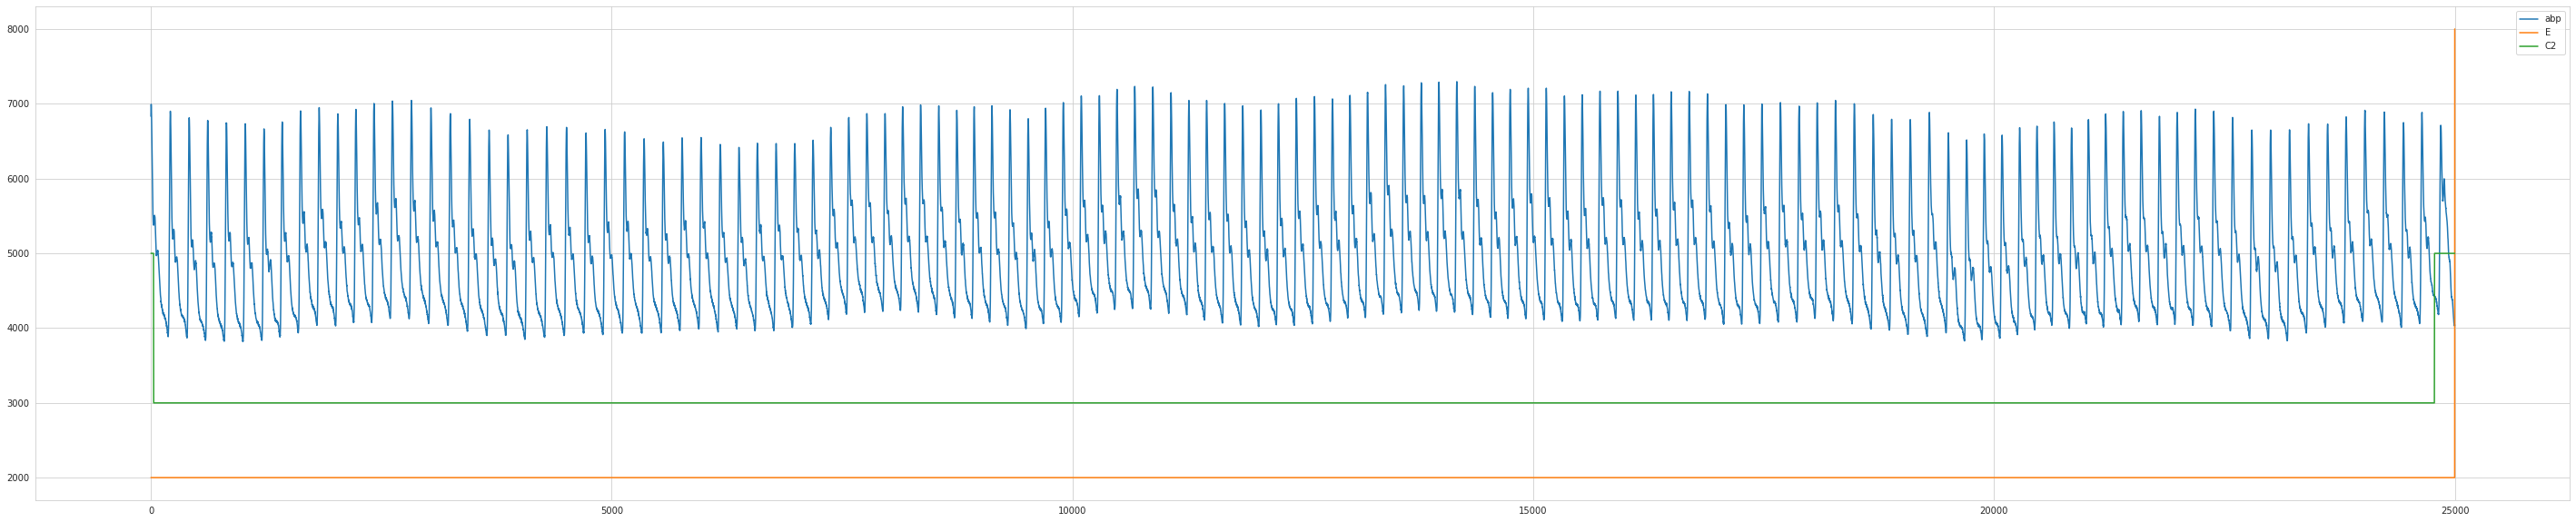

In [94]:
data.loc[0:25000, ["abp", "E", "C2"]].plot()

<AxesSubplot:>

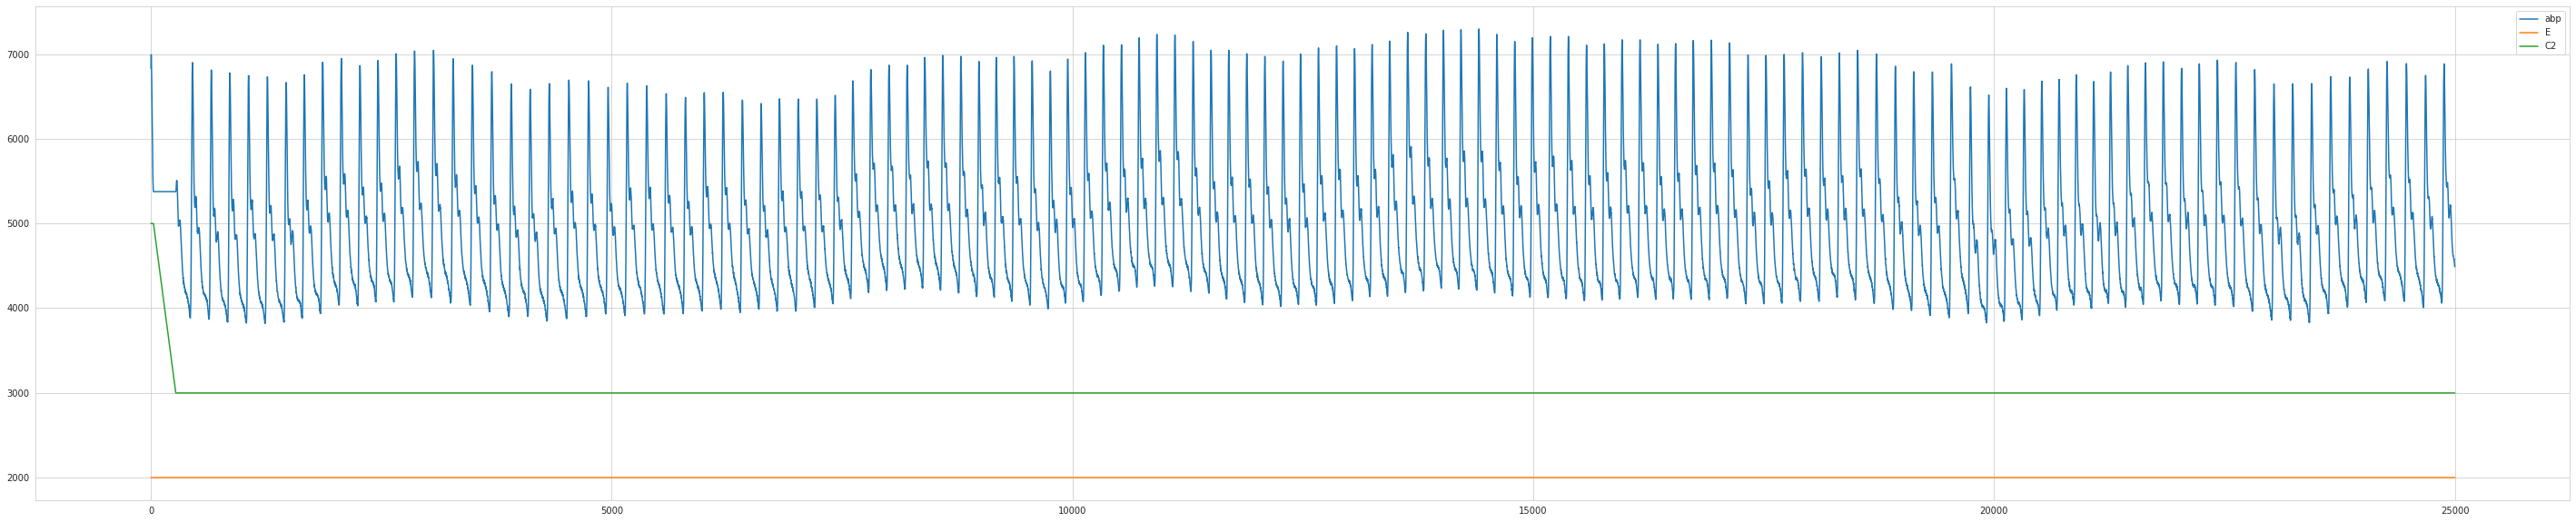

In [104]:
# TODO reset index,sort by time lub set index == time
data_expl.loc[0:25000, ["abp", "E", "C2"]].plot()

<AxesSubplot:>

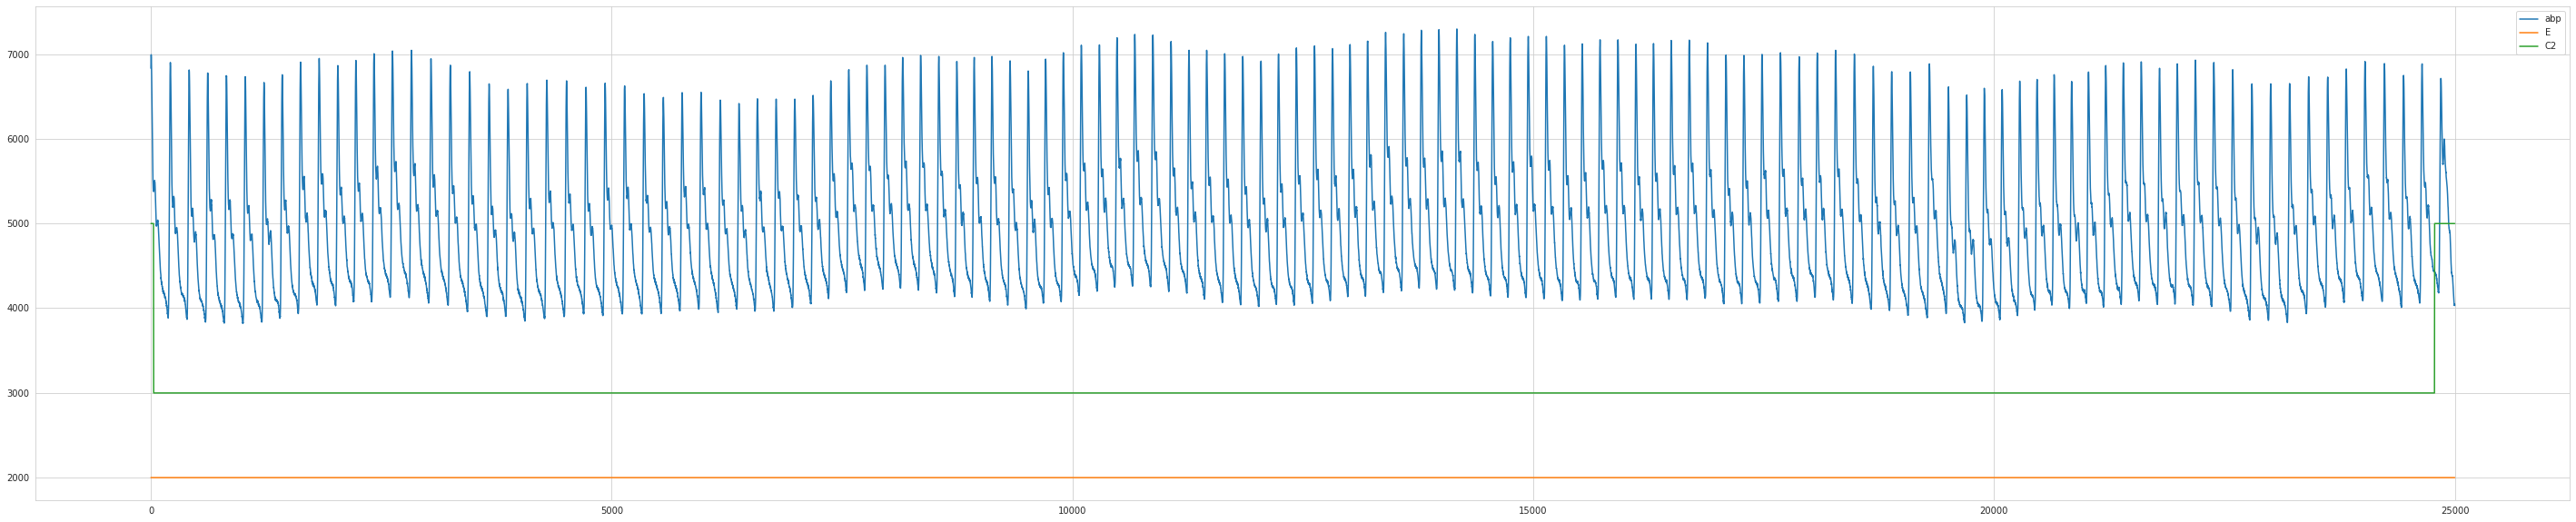

In [105]:
data.loc[data['time'] < 25000, ["abp", "E", "C2"]].plot()

<AxesSubplot:>

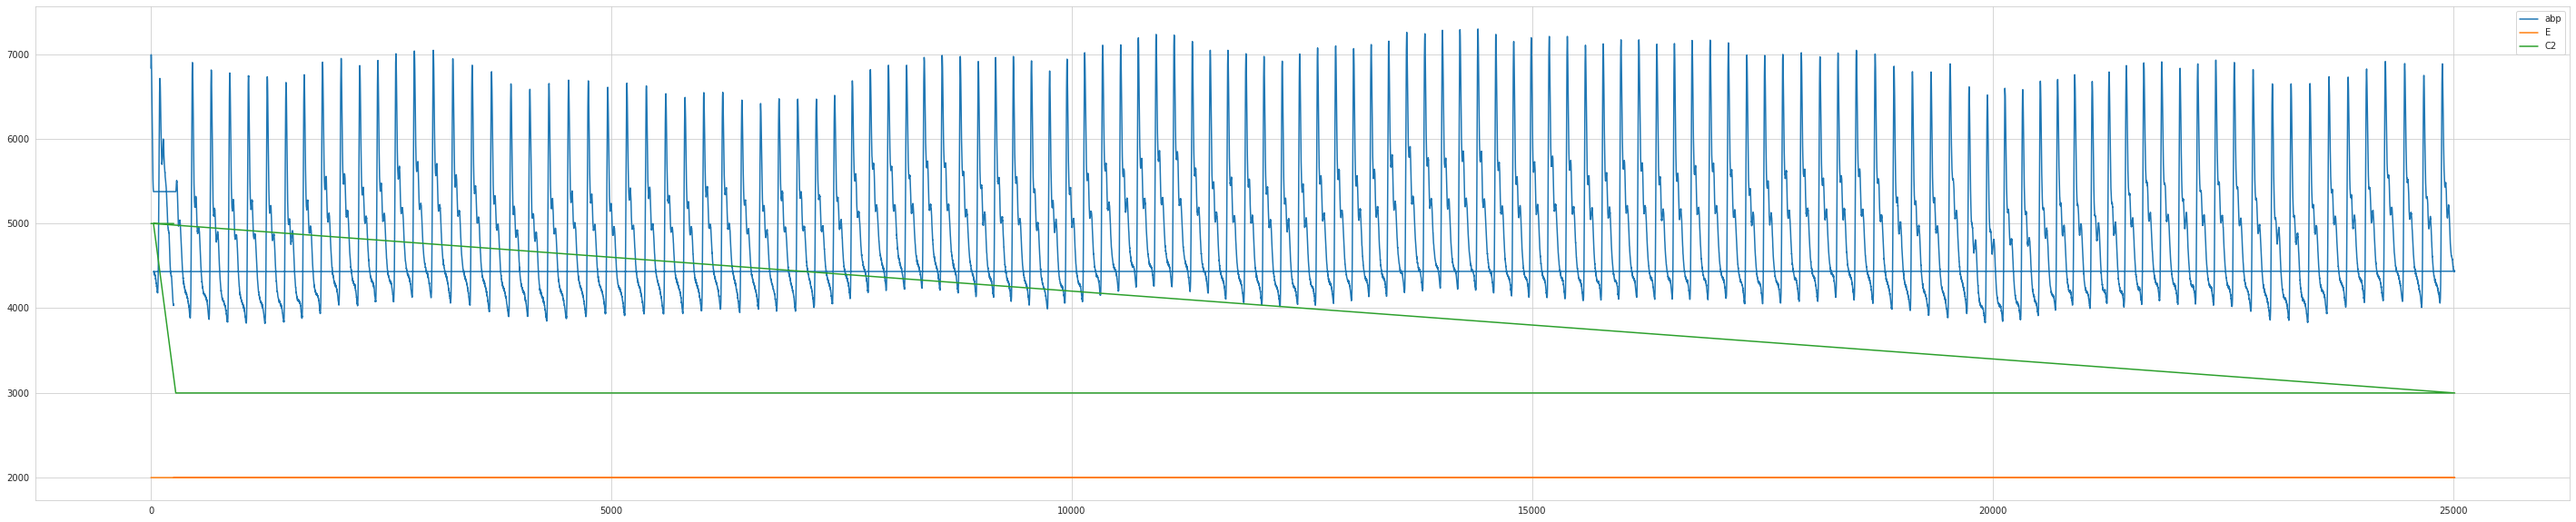

In [106]:
data_expl.loc[data_expl['time'] < 25000, ["abp", "E", "C2"]].plot()

In [107]:
justify_splits_anchor(expert_to_split=expert_to_split,
                      split_recoms=split_recoms,
                      data=data_expl[all_cols],
                      features=features,
                      target_automatic=target)

The rule for automatic cluster 0: 
Precision: 0.99
Coverage: 1.00
The rule for automatic cluster 1: abp_mean > 4739.13 AND abp_max > 7044.00
Precision: 1.00
Coverage: 0.01


In [108]:
justify_splits_tree(expert_to_split=expert_to_split,
                    split_recoms=split_recoms,
                    data=data_expl[all_cols],
                    features=features,
                    target_automatic=target)

['if (abp_min <= 3940.0) then class: 0 (proba: 100.0%) | based on 24,751 samples',
 'if (abp_min > 3940.0) then class: 1 (proba: 100.0%) | based on 269 samples']

## Explain merges
We explain merges in the sam eway as above, but now, decision are expert labels.
We leave the decision if the condition for splitting is sufficient, or is it redundant, or artificial to an expert

In [109]:
target_sur='E2'

In [110]:
knac_merges_recoms

C1      C2  similarity
1  3000.0  5000.0    0.902261

In [111]:
which_recom = 0

merge_recoms=list(knac_merges_recoms.iloc[which_recom, 0:2])

print(merge_recoms)

[3000.0, 5000.0]


<AxesSubplot:>

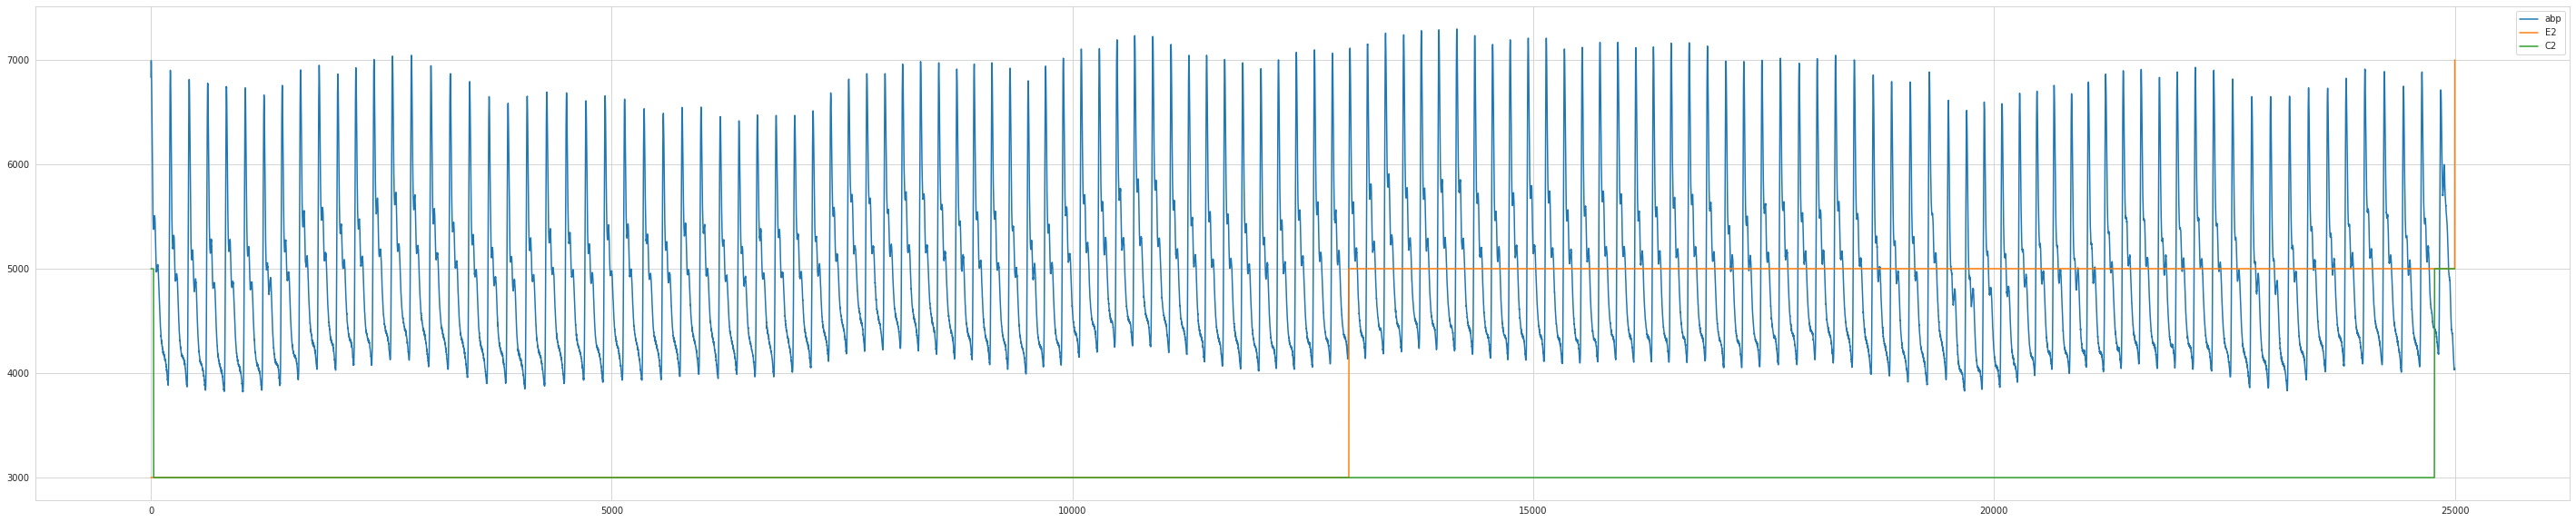

In [112]:
data.loc[0:25000, ["abp", "E2", "C2"]].plot()

<AxesSubplot:>

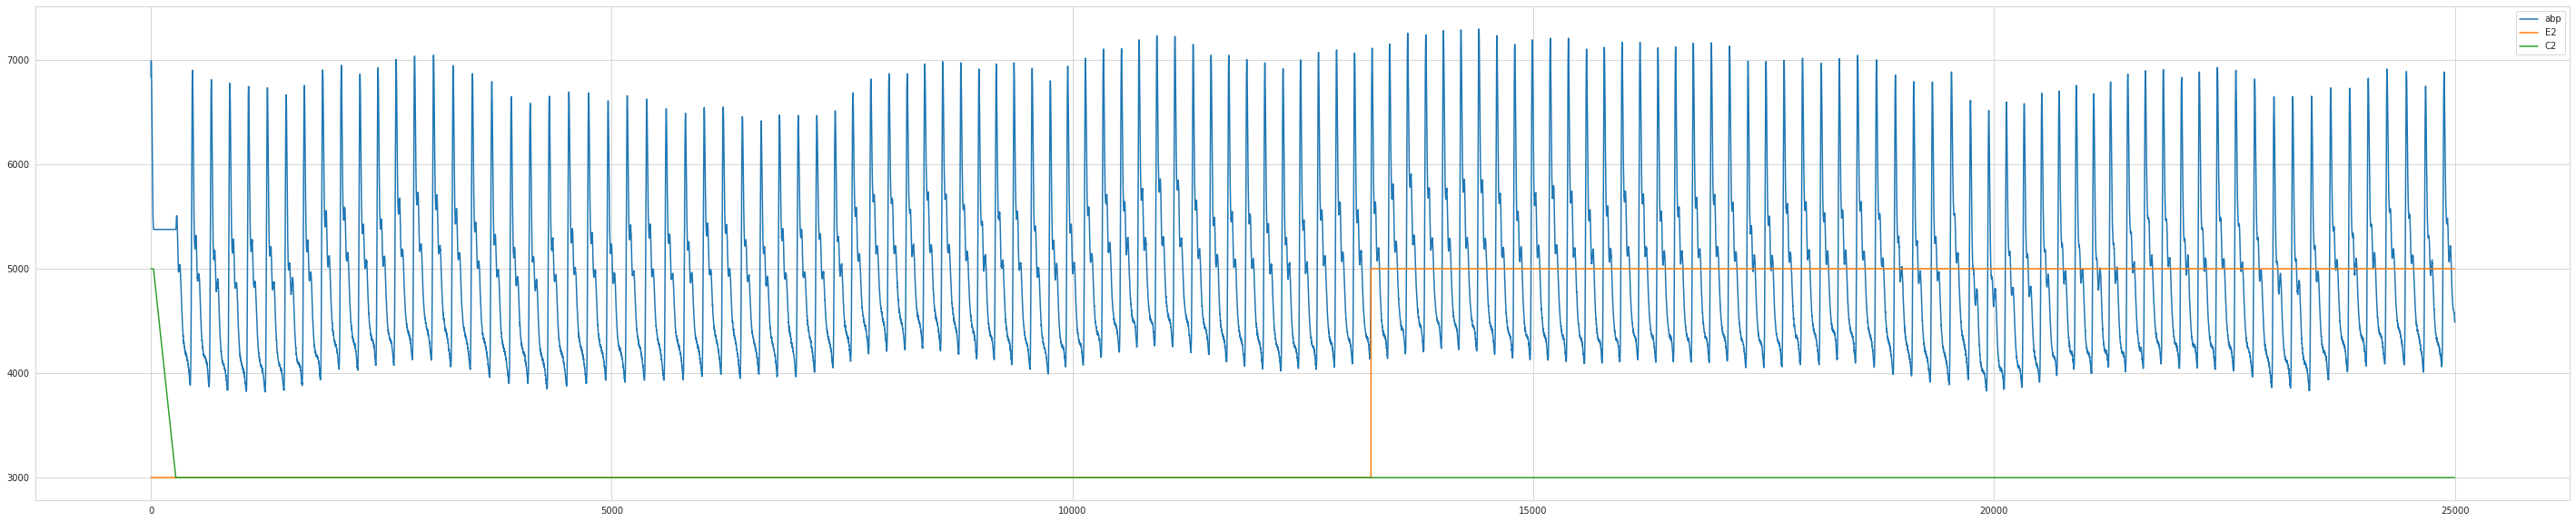

In [113]:
data_expl.loc[0:25000, ["abp", "E2", "C2"]].plot()

In [114]:
justify_merges_anchor(merge_recoms=merge_recoms, data=data_expl[all_cols], features=features, target_expert=target_sur)

/home/mmozolewski/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The rule for automatic cluster 3000.0: abp_max > 6464.00 AND abp_min > 2924.00
Precision: 0.99
Coverage: 0.62
The rule for automatic cluster 5000.0: abp_mean > 4014.84 AND abp_min > 2924.00
Precision: 0.99
Coverage: 0.62


In [115]:
justify_merges_tree(merge_recoms=merge_recoms, data=data_expl[all_cols], features=features, target_expert=target_sur) ###  TODO Czemu tłumaczy to na deepvatsowych (C), a nie Eksperckich

['if (abp_min <= 3940.0) then class: 0 (proba: 52.41%) | based on 24,751 samples',
 'if (abp_min > 3940.0) then class: 1 (proba: 88.35%) | based on 249 samples']

# Observations with enough clusters on window level to take most frequent cluster

In [116]:
#### problem on the beginning of the series ####
# if point belongs
# 1 - windows_size / stride
# cut all (windows_size / stride) / (number_of_cluster)
math.ceil((210 / 8) / 3)

9

In [117]:
deep_vats_clusters

idx clusters  most_freq_cluster  cluster_count
0          0        1                  1              1
1          1        1                  1              1
2          2        1                  1              1
3          3        1                  1              1
4          4        1                  1              1
...      ...      ...                ...            ...
39995  39995        2                  2              1
39996  39996        2                  2              1
39997  39997        2                  2              1
39998  39998        2                  2              1
39999  39999        2                  2              1

[40000 rows x 4 columns]

In [118]:
# Remove beginning of a series:
def remove_obs_based_on_windows(df_clusters_windows_from_dvats, df_clusters_observations_from_dvats, df_data, cluster_col, windows_size, stride):
    number_of_cluster = len(df_clusters_windows_from_dvats[cluster_col].unique())
    print(f"got {number_of_cluster} clusters from DeepVATS")

    clusters_vote_min_count = math.ceil((windows_size / stride) / number_of_cluster)
    df_clusters_observations_from_dvats['cluster_count'] = df_clusters_observations_from_dvats['clusters'].apply(lambda x: len(x.split(', ')))
    return df_data.loc[df_clusters_observations_from_dvats['cluster_count'] >= clusters_vote_min_count, :]

remove_obs_based_on_windows(deep_vats_clusters_windows, deep_vats_clusters, data, 'cluster', 210, 8)

got 3 clusters from DeepVATS


time     abp       E      E2  C    C2  cluster
79        79  4996.0  2000.0  3000.0  0  2999        0
80        80  4972.0  2000.0  3000.0  0  2999        0
81        81  4960.0  2000.0  3000.0  0  2999        0
82        82  4924.0  2000.0  3000.0  0  2999        0
83        83  4908.0  2000.0  3000.0  0  2999        0
...      ...     ...     ...     ... ..   ...      ...
39915  39915  3852.0  8000.0  7000.0  2  6999        2
39916  39916  3848.0  8000.0  7000.0  2  6999        2
39917  39917  3860.0  8000.0  7000.0  2  6999        2
39918  39918  3856.0  8000.0  7000.0  2  6999        2
39919  39919  3860.0  8000.0  7000.0  2  6999        2

[39841 rows x 7 columns]